## Implementation of randomized optimization algorithm for diagonalization

In [2]:

'''
The following code is a part of the code in the paper "Fixed depth hamiltonian simulation via Cartan decomposition". 
This code is used to deal with Pauli operations in our algorithm. 

'''


# -*- coding: utf-8 -*-
__docformat__ = 'google'
"""
Created on Mon Dec 21 15:16:56 2020
A Collection of Methods to calculate useful operations on Pauli Strings. Mostly commutators

@author: Thomas Steckmann
@author: Efekan Kokcu

"""
import numpy as np
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from IPython.display import clear_output
import matplotlib.pyplot as plt
import time
import scipy.io
from decimal import Decimal, getcontext
from joblib import Parallel, delayed
import multiprocessing as multip

ops = ['I','X','Y','Z']
"""Indices for converting from (PauliString) --> String format"""
RULES = [1,3,1,3]
"""
Used for generating the Commutator tables and pauli commutators (efficiently we think)
``
RULES:
    Used to find the multiplication between two paulis represented as indices in a tuple (I == 0, X == 1, Y == 2, Z == 3)
The operation is (index1 + index2*RULES[index1] % 4) = Pauli Matrix result as an index

I * anything: 0 + (Index2)*1 = index2
X * anythong: (1 + (Index2)*3 % 4) gives
                                         1 + 0 = 1 for I, 
                                         (1 + 1*3) % 4 = 0 for X
                                         (1 + 2*3) % 4 = 7 % 4 = 3 for Y
                                         (1 + 3*3) % 4 = 10 % 4 = 2 for Z as index2
These can easily be expanded for Y and Z
``
"""

SIGN_RULES = [[1,1,1,1], 
             [1, 1, 1j, -1j],
             [1, -1j, 1, 1j],
             [1, 1j, -1j, 1]]
"""
Rules for computing the sign of two commutators
```
SIGN_RULES: 
    Gives the multiplication sign rules for multiplying Pauli Matricies (ex. X*Y -> iZ)
    
  I  X  Y  Z
I +  +  +  +
X +  +  +i -i
Y +  -i +  +i
Z +  +i -i +

Order: row * column
```
"""

#The Pauli Matricies in matrix form
X = np.array([[0,1],[1,0]])
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
I = np.array([[1,0],[0,1]])
paulis = [I,X,Y,Z]
#Allows for indexing the Pauli Arrays (Converting from tuple form (0,1,2,3) to string form IXYZ)

def Plist2Hmat(Plist):
    List = []
    op = ""
    for j in range(len(Plist)):
        if Plist[j] == 0:
            op += "I" 
        elif Plist[j] == 1:
            op += "X"
        elif Plist[j] == 2:
            op += "Y"
        elif Plist[j] == 3:
            op += "Z"
    List.append(op)
    #List.reverse()
    H = SparsePauliOp(List, 1)
    Hmat = Operator(H)
    return Hmat.data

def commutatePauliString(a,tupleA,b,tupleB, comm_coefs = None, comm_table = None):
    """Computes the commutator of two Pauli Strings represented as a tuple
    
    If a commutator table is passed, the operation is much more efficient

    Args:
        a (np.complex128): 
            The coefficient of the first Pauli String term
        tupleA (Tuple, integer): 
            tuple representation of the first Pauli String, or the index in the commutator table
        b (np.complex128): 
            The coefficient of the second Pauli String term
        tupleB (tuple, int): 
            tuple representation of the second Pauli String, or the index in the commutator table
        
    
    Returns:
        c (np.complex128):
            The coefficient of the result [a*TupleA,b*TupleB] = c*TupleC, where c is the Structure Constant * a * b
        tupleC (tuple): 
            the elementwise commutator of the PauliString, ignoring coefficients. 
    """
    
    if type(tupleA)==tuple:
    
        sites = len(tupleA)
        #builds up the result Tuple C
        tupleC = ()

        signForward = 1 # sign(a.b)
        signBackward = 1 # sign(b.a) 


        #Iterate elementwise over the tuple
        for i in range(sites):
            #tupleC is the tuple representation of the result of the commutator 
            tupleC += (((tupleA[i] + tupleB[i]*RULES[tupleA[i]]) % 4),)
            #Complex integer product of all the elementwise multiplications going forward
            signForward = signForward * SIGN_RULES[tupleA[i]][tupleB[i]]
            #Complex integer product of all the elementwise multiplications going backward
            signBackward = signBackward * SIGN_RULES[tupleB[i]][tupleA[i]]

        #Checks the signs forward and backwards. If they are the same, it commutes
        if signForward == signBackward:
            return (0,tupleC)
        else:
            c = a * b * 2*signForward
            return c, tupleC
    
    else:
        return (a*b*comm_coefs[int(tupleA)][int(tupleB)]), comm_table[int(tupleA)][int(tupleB)] 
    
    
    

def multiplyPauliString(a,tupleA,b,tupleB):
    """Computes the multiplication of two Pauli Strings represented as a tuple

    Args:
        a (np.complex128): 
            The coefficient of the first Pauli String term
        tupleA (Tuple):
            tuple representation of the first Pauli String
        b (np.complex128):
            The coefficient of the second Pauli String term
        tupleB (Tuple): 
            tuple representation of the second Pauli String

    Returns:
        c (np.complex128):
            The coefficient of the result a*TupleA . b*TupleB = c*TupleC, where c (the sign of the product of Paulis * a * b)
        tupleC (tuple) :
            the elementwise product of the PauliString, ignoring coefficients. 
    """
      
    sites = len(tupleA)
    #builds up the result Tuple C
    tupleC = ()
    sign = 1 # sign(a.b)
    
    #Iterate elementwise over the tuple
    for i in range(sites):
        #tupleC is the tuple representation of the result of the commutator 
        tupleC += (((tupleA[i] + tupleB[i]*RULES[tupleA[i]]) % 4),)
        #Complex integer product of all the elementwise multiplications
        sign = sign * SIGN_RULES[tupleA[i]][tupleB[i]]
        
    c = a * b * sign
    return c, tupleC  



def multiplyLinComb(A,tuplesA,B,tuplesB):
    '''Returns multiplication of two linear combinations of Pauli terms 
    '''

    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = multiplyPauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]
            if flag == 0:
                C.append(term[0])
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC





def simplifyLinComb(A,tuples):
    '''Modifies the input lists
    
    Simplifies lin comb of Pauli matrices that it eats. Doesn't return anything
    Args:
        A: A list
        tuples: A list
    '''
    
    size = len(A)
    
    index = 0
    
    while index < size:
        flag = 0
        for i in range(index):
            if tuples[i]==tuples[index]:
                A[i] = A[i]+A[index]
                A.pop(index)
                tuples.pop(index)
                flag = 1
                size = size-1
                break
                
        if flag == 0:
            index = index + 1
            
def commutateLinComb(A,tuplesA,B,tuplesB,accur):
    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = commutatePauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]
            if (flag == 0) & (abs(term[0])>accur):
                C.append(term[0])
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC



def multiplyLinCombRound(A,tuplesA,B,tuplesB, accur):
    '''
    Returns multiplication of two linear combinations of Pauli terms, and rounds things that are smaller than accur to zero. 
    '''

    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = multiplyPauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]
            if (flag == 0) & (abs(term[0])>accur):
                C.append(term[0])
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC


def commutateLinCombWithoutFactorOf2(A,tuplesA,B,tuplesB,accur):
    a = len(A)
    b = len(B)
    
    C = []
    tuplesC = []
    csize = 0
    
    for i in range(a):
        for j in range(b):
            term = commutatePauliString(A[i],tuplesA[i],B[j],tuplesB[j])
            flag = 0
            for k in range(csize):
                if tuplesC[k]==term[1]:
                    flag = 1
                    C[k] = C[k]+term[0]/2
            if (flag == 0) & (abs(term[0])>accur):
                C.append(term[0]/2)
                tuplesC.append(term[1])
                csize = csize + 1
    
    return C, tuplesC


def cleancoefs(coefs, accur):
    '''Rounds coefficients that are smaller than accur to zero.
    '''
    
    for i in range(len(coefs)):
        if abs(coefs[i])<accur:
            coefs[i] = 0

In [ ]:
'''
Based upon the above code, we define functions as follows, which are used to compute the cost function value and its gradient.
For example, the function "Indfinder" helps find a Pauli string P_i for given Q,h,P_j such that P_ihP_j = Q. 
Once such P_i is found, the function "coeff" is used to the coefficient, and together our cost function is computed.

'''

def magic(numList):
    s = ''.join(map(str, numList))
    return int(s)

def Plist2ind(plist):
    x = magic(plist)
    x = str(x)
    return int(x,4)


def Indfinder(Q,h,P_j):  ## P_ihP_j = Q => P_i = QP_jh -> i = f(j)
    result = multiplyPauliString(1,P_j,1,h)
    P_i = multiplyPauliString(1,Q,1,result[1])
    return list(P_i[1])

def coeff(P_i,h,P_j):
    result = multiplyPauliString(1,P_i,1,h)
    value = result[0]
    result_1 = multiplyPauliString(1,result[1],1,P_j)
    value = value*result_1[0]
    return value

def Ind2Plist(Ind, num_q):
    result = []
    while Ind > 0:
            result.insert(0, Ind % 4)
            Ind = Ind // 4
    
    if len(result) < num_q:
        while num_q - len(result) > 0:
            result.insert(0,0)
    return result

def Ind2PlistZ(Ind, num_q):
    result = []
    while Ind > 0:
            result.insert(0, 3*(Ind % 2))
            Ind = Ind // 2
    
    if len(result) < num_q:
        while num_q - len(result) > 0:
            result.insert(0,0)
    return result


In [3]:
'''
We define a model Hamiltonian using Qiskit tools. Here is the XXZ model. One can similarly define the Hubbard model.
The model defined has a slight different parameter from the target Hamiltonian we want to diagonalize.
We eigen-decompose this model and use the unitary as the initialization for diagonalizing the target Hamiltonian.
'''
import matplotlib.pyplot as plt
from numpy import linalg as LA
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import SparsePauliOp
from qiskit.quantum_info.operators import Operator
from qiskit_aer import AerSimulator
from qiskit.circuit import QuantumCircuit
from scipy.sparse.linalg import eigs
from scipy import sparse
import math


num_q = 4

J = 1
Delta = 0.8
List_1 = []
op = ""
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "ZZ"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()
H1 = SparsePauliOp(List_1, Delta*np.ones(num_q-1))  

List_1 = []
op = ""
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "YY"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()
H2 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

List_1 = []
op = ""
for i in range(num_q-1):
    op = ""
    for k in range(i):
        op += "I"
    op += "XX"
    for k in range(i+1,num_q-1):
        op += "I"
    List_1.append(op)

List_1.reverse()
H3 = SparsePauliOp(List_1, J*np.ones(num_q-1))  

H = SparsePauliOp.sum([H1,H2,H3])
print(H)
# Ordering in SparsePauliOp e.g. IIIIIIZZ is the measurement of Z gates on the first two qubits and so forth.

Hmat = Operator(H)
#Hmat = sparse.csr_matrix(Hmat)

#e, v = eigs(Hmat,k=20)
e, V1 = np.linalg.eigh(Hmat)



SparsePauliOp(['IIZZ', 'IZZI', 'ZZII', 'IIYY', 'IYYI', 'YYII', 'IIXX', 'IXXI', 'XXII'],
              coeffs=[0.8+0.j, 0.8+0.j, 0.8+0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j, 1. +0.j,
 1. +0.j])


In [4]:
'''
Here we define the target Hamiltonian we want to diagonalize.
'''
Hamiltonian = [[1,1,0,0], [0,1,1,0], [0,0,1,1], [2,2,0,0], [0,2,2,0], [0,0,2,2], [3,3,0,0], [0,3,3,0], [0,0,3,3]]
coeffH = [1,1,1,1,1,1,1,1,1]
num_q = 4
h_cartan = []
for  j in range(2**num_q):
    P_j = Ind2PlistZ(j,num_q)
    if P_j == [0,0,0,0]:
        h_cartan.append(P_j)
    else:
        for j in range(num_q):
            if P_j[j] == 1:
                P_j[j] = 3
        h_cartan.append(P_j)

In [5]:

'''
Here we define key functions for our randomized algorithm. 
As mentioned in the paper, the following code specifies the recursive relations for evaluating the cost function and its gradient.

'''
M = len(Hamiltonian)
N = 2**num_q
d = N**2

Basis = []

for j in range(d):
    P_j = Ind2Plist(j,num_q)
    Basis.append(P_j)

not_h_cartan =  [item for item in Basis if item not in h_cartan]     
dim_not_h = d - len(not_h_cartan)

def basic_loss_f(m,x1,x2,p,ind_j):
    R1 = x1[:d]
    Theta1 = x1[d:]
    R2 = x2[:d]
    Theta2 = x2[d:]
    
    H_m = Hamiltonian[m]
    P_j = Ind2Plist(ind_j,num_q)
    i_j = Indfinder(p,H_m,P_j)
    ind_i_j = Plist2ind(i_j)
    
    return  np.real(R1[ind_i_j]*R2[ind_j]*np.exp(1j*(-Theta1[ind_i_j]+Theta2[ind_j]))*coeff(i_j,H_m,P_j)*coeffH[m])


def f_p_loss_delta(y,x,p,index):
    

    delta = 0
    for m in range(M):
        for j in range(len(index)):
            ind_J = index[j]
            delta += 2*(basic_loss_f(m,x,y,p,ind_J) - basic_loss_f(m,x,x,p,ind_J))
            #print('error:', j, delta)
            
    for m in range(M):
        H_m = Hamiltonian[m]
        for j in range(len(index)):
            ind_J = int(index[j])
            P_j = Ind2Plist(ind_J,num_q)
            i_j = Indfinder(p,H_m,P_j)
            ind_i_j = Plist2ind(i_j)
            if ind_i_j in index:
                delta += basic_loss_f(m,y,y,p,ind_J) - basic_loss_f(m,y,x,p,ind_J) - basic_loss_f(m,x,y,p,ind_J) + basic_loss_f(m,x,x,p,ind_J)
    
    
    return delta


def f_p_loss(x,p):
    
    f = 0
    
    for m in range(M):
        for j in range(d):
            f +=  basic_loss_f(m,x,x,p,j)
    
    f = np.real(f)
    
    return f


def f_p_grad(x,p,index):
    R = x[:d]
    Theta = x[d:]

    grad = x*0

    for j in range(len(index)):
        index_j = int(index[j])
        P_rind = Ind2Plist(index_j,num_q)
        value_r = 0
        value_theta = 0
        for m in range(M):
            H_m = Hamiltonian[m]
            i_j = Indfinder(p,H_m,P_rind)
            ind_i_j = Plist2ind(i_j)
            value_r += R[ind_i_j]*np.exp(1j*(Theta[ind_i_j]-Theta[index_j]))*coeff(P_rind,H_m,i_j)*coeffH[m]
            value_theta += R[index_j]*value_r
        grad[index_j] += 4*np.real(value_r)
        grad[index_j+d] += 4*np.imag(value_theta)
    
    return grad


def basic_loss_Phi(x1,x2,P,ind_j):
    R1 = x1[:d]
    Theta1 = x1[d:]
    R2 = x2[:d]
    Theta2 = x2[d:]
    
    Identity = Ind2Plist(0,num_q)
    
    P_j = Ind2Plist(ind_j,num_q)
    j_P = Indfinder(P,Identity,P_j)
    ind_j_P = Plist2ind(j_P)
        
    return np.real(R1[ind_j_P]*R2[ind_j]*np.exp(1j*(-Theta1[ind_j_P]+Theta2[ind_j]))*coeff(j_P,Identity,P_j))

def Phi_P_loss_delta(y,x,P,index):
    
    
    delta = 0
    Identity = Ind2Plist(0,num_q)
    
    for j in range(len(index)):
        ind_J = index[j]
        P_j = Ind2Plist(ind_J,num_q)
        j_P = Indfinder(P,Identity,P_j)
        ind_j_P = Plist2ind(j_P)

        if ind_j_P in index:
            delta += basic_loss_Phi(y,y,P,ind_J) - basic_loss_Phi(x,x,P,ind_J) 
        else: 
            delta += basic_loss_Phi(x,y,P,ind_J) - basic_loss_Phi(x,x,P,ind_J) + basic_loss_Phi(y,x,P,ind_j_P) - basic_loss_Phi(x,x,P,ind_j_P)
            
    return delta
    



def Phi_P_loss(x,P):
    phi_P = 0
    
    for j in range(d):
        phi_P += basic_loss_Phi(x,x,P,j)
        
    phi_P = np.real(phi_P)
    
    return phi_P




def Phi_P_grad(x,P,index):
    R = x[:d]
    Theta = x[d:]
    
    grad_P = x*0
    Identity = Ind2Plist(0,num_q)

    for j in range(len(index)):
        index_j = int(index[j])
        P_rind = Ind2Plist(index_j,num_q)
        j_P = Indfinder(P,Identity,P_rind)
        ind_j_P = Plist2ind(j_P)
        
        value = 4*R[ind_j_P]*np.exp(1j*(-Theta[ind_j_P]+Theta[index_j]))*coeff(j_P,Identity,P_rind)
    
        grad_P[index_j] += np.real(value)
        grad_P[index_j+d] += -np.imag(R[index_j]*value)
    
    return grad_P



In [7]:
'''
This code outputs the Frobenius error between the original Hamiltonian and the one numerically after optimization.
'''

def K_output(x):
    R = x[:d]
    R = R/np.linalg.norm(R)
    Theta = x[d:]
    
    K = np.zeros((N,N),  dtype=np.complex_)
    for j in range(d):
        P_j = Ind2Plist(j,num_q)
        K += R[j]*np.exp(1j*Theta[j])*Plist2Hmat(P_j)
    return K

def H_error(weights):

    K_result = K_output(weights)
    
    H = np.zeros((2**num_q,2**num_q),  dtype=np.complex_)

    for m in range(len(Hamiltonian)):
        H += Plist2Hmat(Hamiltonian[m])*coeffH[m]

    KdHK = np.matmul(np.transpose(np.conj(K_result)), H)
    KdHK = np.matmul(KdHK,K_result)


    h_0 = H*0
    for i in range(len(h_cartan)):
        h_0 += np.trace(np.matmul(KdHK,Plist2Hmat(h_cartan[i])))/2**num_q*Plist2Hmat(h_cartan[i])

    approx_H = np.matmul(h_0, np.transpose(np.conj(K_result)))
    approx_H = np.matmul(K_result, approx_H)
    approx_H = (approx_H + np.transpose(np.conj(approx_H)))/2

    return np.linalg.norm(H-approx_H, 'fro')

#K_result = K_output(weights)
#print(np.linalg.norm(np.matmul(np.transpose(np.conj(K_result)),K_result)-np.eye(2**num_q), 'fro'))

In [8]:
"""optimization phase"""


"""initial step"""
#initial_weights[:d] += 0.01*np.random.normal(0,1,d)

#mat = scipy.io.loadmat('w0')
#W = mat['W']

#initial_weights = np.ones(2*d)
#initial_weights[:5] = np.ones(5) #ans_weights + 0.001*np.random.normal(0,2*np.pi,2*d) #np.ones(2*d) 
#initial_weights[d:] = -np.ones(d)*np.pi/4
#initial_weights[:d] = initial_weights[:d]/np.linalg.norm(initial_weights[:d])
#initial_weights = W #W.flatten()
T = 10000
a = 1e-02
penalty = 1
num_s = 16
max_cpus = int(multip.cpu_count())
noise_C = 0.001

f_p_values = np.zeros(len(not_h_cartan))
Phi_P_values = np.zeros(d-1)
f_value = 0
Phi_value = 0

f_grad = initial_weights*0
Phi_grad = initial_weights*0
F_grad = initial_weights*0

weights_x = np.zeros(2*d)
weights_y = np.zeros(2*d)
weights_next = np.zeros(2*d)



index_1 = np.random.choice(d, num_s, replace=False)

for j in range(len(not_h_cartan)):
    plist = not_h_cartan[j]
    f_p_values[j] = f_p_loss(initial_weights,plist)
    f_j_grad = f_p_grad(initial_weights,plist,index_1)
        
    f_grad += f_p_values[j]*f_j_grad
    f_value += f_p_values[j]**2
for i in range(1,d):
    Plist = Ind2Plist(i,num_q)
    Phi_P_values[i-1] = Phi_P_loss(initial_weights, Plist)
    Phi_i_grad = Phi_P_grad(initial_weights,Plist,index_1)

    Phi_grad += Phi_P_values[i-1]*Phi_i_grad
    Phi_value += Phi_P_values[i-1]**2

F_grad = f_grad + penalty*Phi_grad

#R = initial_weights[:d]/np.linalg.norm(initial_weights[:d])
#noise_mag = np.linalg.norm(F_grad[:d] - np.dot(F_grad[:d], R)*R)
#noise = np.random.normal(0,1,num_s)
#noise = noise_C*noise_mag*noise/np.linalg.norm(noise)  ## noise only for sampled indices
     
#F_ortho = np.zeros(2*d)
#F_grad_r_perturbed = F_grad
#F_grad_r_perturbed[index_1] += noise
#F_ortho[:d] = F_grad_r_perturbed[:d] - np.dot(F_grad_r_perturbed[:d], R)*R
#F_ortho[d:] = F_grad[d:]*0

weights_y += initial_weights
weights_y[index_1] += -a*F_grad[index_1]

weights_next += weights_y

R = weights_next[:d]
R_mag = np.linalg.norm(weights_next[:d])
weights_next[:d] = R/np.linalg.norm(R)


cost_mat = np.empty((0,T), int)
weight_mat = np.empty((0,T), int)
iteration = 0
loss = 0 

 
cost = []
cost_f = []
Weights = []
weights_x += initial_weights

for iteration in range(T):
    #start = time.time()
    f_value = 0
    f_grad = weights_y*0
    Phi_value = 0
    Phi_grad = weights_y*0
    iteration = iteration + 1 

    ## check 
    results = Parallel(n_jobs=max_cpus)(delayed(f_p_loss_delta)(weights_y, weights_x, not_h_cartan[k], index_1) for k in range(len(not_h_cartan)))
    for j in range(len(results)):
        #f_p_values[j] = f_p_loss(weights_next,plist)
        f_p_values[j] += results[j] 
        f_p_values[j] *= (1/R_mag)**2
        #print(j,f_p_values[j] - f_p_loss(weights_next,plist))

    results = Parallel(n_jobs=max_cpus)(delayed(Phi_P_loss_delta)(weights_y, weights_x, Ind2Plist(i,num_q), index_1) for i in range(1,d))
    for i in range(1,d):
        Plist = Ind2Plist(i,num_q)
        #Phi_P_values[i-1] = Phi_P_loss(weights_next, Plist)
        Phi_P_values[i-1] += results[i-1]
        Phi_P_values[i-1] *= (1/R_mag)**2
        #print(i,Phi_P_values[i-1] - Phi_P_loss(weights_next, Plist))

    index_1 = np.random.choice(d, num_s, replace=False)

    results = Parallel(n_jobs=max_cpus)(delayed(f_p_grad)(weights_next, not_h_cartan[k], index_1) for k in range(len(not_h_cartan)))

    for j in range(len(not_h_cartan)):
        f_grad += f_p_values[j]*results[j]
        f_value += f_p_values[j]**2
    
    results = Parallel(n_jobs=max_cpus)(delayed(Phi_P_grad)(weights_next, Ind2Plist(i,num_q), index_1) for i in range(1,d))
    
    for i in range(1,d):
        Phi_grad += Phi_P_values[i-1]*results[i-1]
        Phi_value += Phi_P_values[i-1]**2
    
    F_grad = f_grad + penalty*Phi_grad
    
    #R = weights_next[:d]/np.linalg.norm(weights_next[:d])
    #noise_mag = np.linalg.norm(F_grad[:d] - np.dot(F_grad[:d], R)*R)
    #noise = np.random.normal(0,1,num_s)
    #noise = noise_C*noise_mag*noise/np.linalg.norm(noise)  ## noise only for sampled indices
     
    #F_ortho = np.zeros(2*d)
    #F_grad_r_perturbed = F_grad
    #F_grad_r_perturbed[index_1] += noise
    #F_ortho[:d] = F_grad_r_perturbed[:d] - np.dot(F_grad_r_perturbed[:d], R)*R
    #F_ortho[d:] = F_grad[d:]*0
    
    weights_x = np.zeros(2*d)
    weights_x += weights_next
    
    weights_y = np.zeros(2*d)
    weights_y += weights_x
    weights_y[index_1] += -a*F_grad[index_1]
    
    weights_next = np.zeros(2*d)
    weights_next += weights_y
    
    R = weights_next[:d]
    R_mag = np.linalg.norm(weights_next[:d])
    weights_next[:d] = R/np.linalg.norm(R)
    
    
    #Weights.append(weights_next)
    loss = f_value + penalty*Phi_value
    clear_output(wait=True)
    #mu = np.linalg.norm(f_grad + Phi_grad)**2/loss
    
    #print('Loss and mu:',loss, mu)
    print('Loss and iter:',loss,iteration, f_value, np.sqrt(Phi_value*N))
    #print('orthogonality:',measure_ortho(weights_x))
    #print('difference:', measure_ortho(weights_x) - Phi_value*N)
    #print('R:',weights_next[:d])
    #print('Theta:',weights_next[d:])
    #plt.plot(cost)
    #plt.yscale('log', base=10)
    #plt.xlabel('iteration')
    #plt.title('KHK Optimization')
    #plt.show()
    cost.append(loss.flatten())
    #end = time.time()
    #print(end-start)
Cost = np.asarray(cost)
scipy.io.savemat('cost_XYZ.mat', {'cost': Cost})

print(H_error(initial_weights))
print(H_error(weights_next))

#WEIGHTS = np.asarray(Weights)
#cost_mat = np.append(cost_mat, np.transpose(Cost), axis = 0)
#weight_mat = np.append(weight_mat, np.transpose(WEIGHTS), axis = 0)
#time_mat = np.append(time_mat, np.transpose(TIME), axis = 0)
    
#scipy.io.savemat('rcd_cost.mat', {'rcd_cost': Cost})
#scipy.io.savemat('rcd_weight.mat', {'rcd_weight': WEIGHTS})
#scipy.io.savemat('rcd_time.mat', {'rcd_time': TIME})



Loss and iter: 1.793770641160545e-08 10000 2.0673984207071055e-09 0.0005039096425495086
0.800120128295449
0.0034226135045974985


In [3]:
'''
We load the data obtained from the above optimization, the cost function values.
The following is not immediately obtained. We ran the above algorithm four times with four different initializations.
'''

mat = scipy.io.loadmat('cost_XYZ_0.1.mat')
X1 = mat['cost']

mat = scipy.io.loadmat('cost_XYZ_0.5.mat')
X2 = mat['cost']

mat = scipy.io.loadmat('cost_XYZ_0.8.mat')
X3 = mat['cost']

mat = scipy.io.loadmat('cost_XYZ_1.2.mat')
X4 = mat['cost']




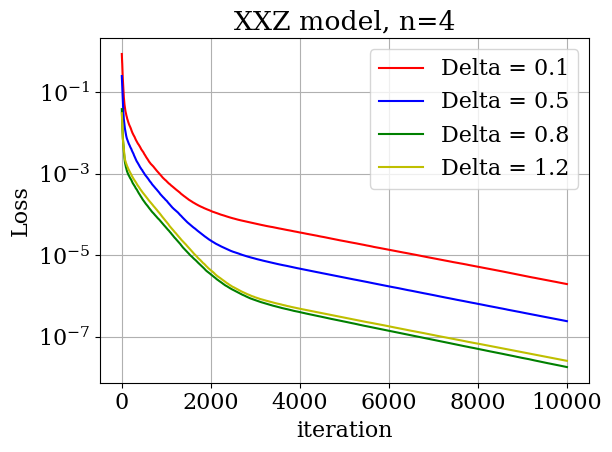

In [10]:
'''
In the folloiwng codes, we plot the data loaded above.
'''


import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.io



fontsize = 16

num_p = 36

nice_fonts = {

# Use LaTeX to write all text

"text.usetex": False,

"font.family": "serif",

# Use 10pt font in plots, to match 10pt font in document

"axes.labelsize": fontsize ,

"font.size": fontsize ,

# Make the legend/label fonts a little smaller

"legend.fontsize": fontsize,

"xtick.labelsize": fontsize,

"ytick.labelsize": fontsize,

}

matplotlib.rcParams.update(nice_fonts)

#data load




#plot
plt.figure()

# Plot mean learning curve for GD and RCD function values
plt.plot(X1, color='r', label='Delta = 0.1')
plt.plot(X2, color='b', label='Delta = 0.5')
plt.plot(X3, color='g', label='Delta = 0.8')
plt.plot(X4, color='y', label='Delta = 1.2')


plt.yscale('log', base=10)


plt.title('XXZ model, n=4')
plt.xlabel('iteration')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.tight_layout()


#plt.axes([.65, .6, .2, .2], facecolor='w')
#plt.scatter(x1,Z_mat[:,0])
#plt.scatter(x2,Z_mat[:,1])
#plt.yscale('log', base=10)
#plt.ylim(np.min(Z_mat)*0.1, np.max(Z_mat)*1.1)
#plt.title('Error')
#plt.grid()

plt.savefig('XXZ.png')


